## Before starting

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [46]:
!nvidia-smi

Thu Jul  4 10:53:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |    427MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [47]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv10

**NOTE:** Currently, YOLOv10 does not have its own PyPI package. Therefore, we need to install the code from the source.

In [48]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**NOTE:** We will also install two additional packages: [`roboflow`](https://github.com/roboflow/roboflow-python) to download the dataset from [Roboflow Universe](https://universe.roboflow.com/), which we will use to train our model, and [`supervision`](https://github.com/roboflow/supervision), which we will use for visualizing the results.

In [49]:
!pip install -q supervision roboflow

## Download pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [50]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 1.2G
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt.1
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt.2
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt.1
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt.2
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt.1
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt.2
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt.1
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt.2
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt.1
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt.2
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt.1
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt.2


## Download example data

**NONE:** Let's download few example images to test.

In [51]:
!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh {HOME}/data

total 312K
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg.1
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg.2


## Inference with Pre-trained COCO Model

**NOTE:** YOLOv10 is based on YOLOv8, and like YOLOv8, it can be used in both CLI and SDK modes.

### 💻 CLI

In [52]:
%cd {HOME}

!yolo task=detect mode=predict conf=0.25 save=True \
model={HOME}/weights/yolov10n.pt \
source={HOME}/data/dog.jpeg

/content
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2762608 parameters, 63840 gradients, 8.6 GFLOPs

image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 dog, 95.2ms
Speed: 3.1ms preprocess, 95.2ms inference, 157.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NONE:** Let's display result.

/content


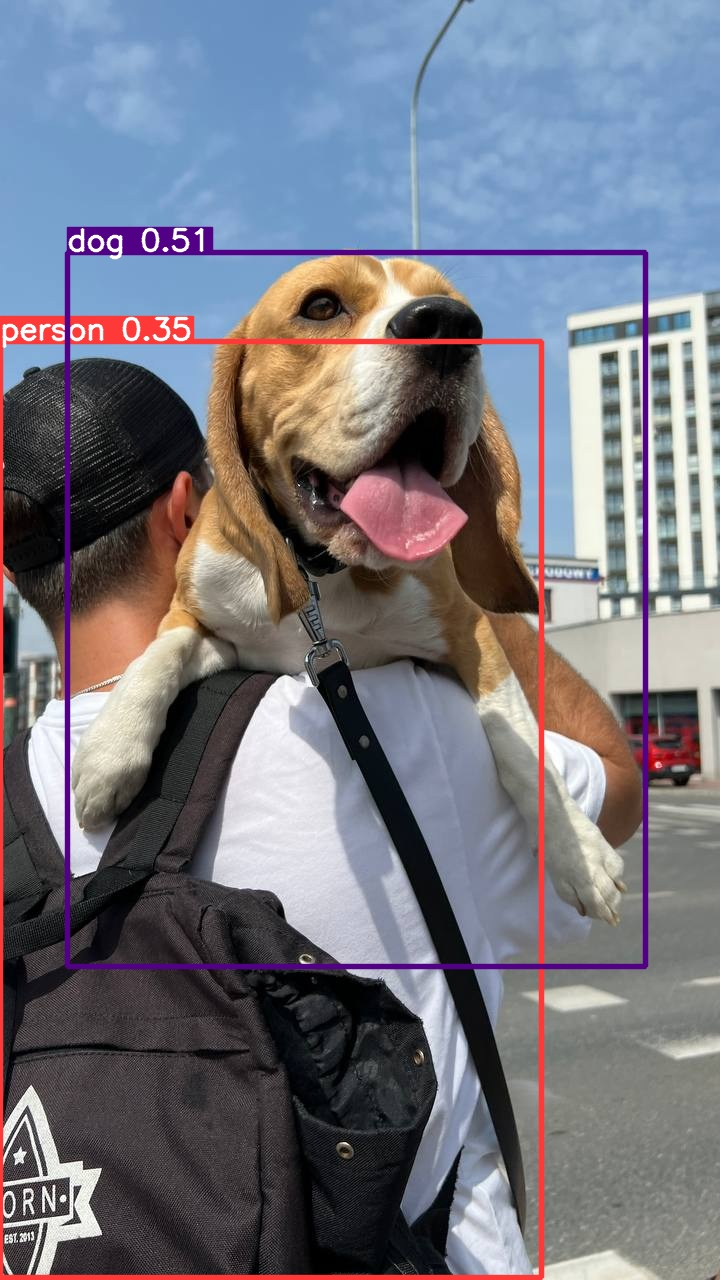

In [53]:
%cd {HOME}

from IPython.display import Image

Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

In [54]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
results = model(source=f'{HOME}/data/dog.jpeg', conf=0.25)


image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 dog, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


In [55]:
results[0].boxes.xyxy

tensor([[6.7041e+01, 2.5264e+02, 6.4549e+02, 9.6621e+02],
        [7.4646e-01, 3.4156e+02, 5.4170e+02, 1.2773e+03]], device='cuda:0')

In [56]:
results[0].boxes.conf

tensor([0.5090, 0.3536], device='cuda:0')

In [57]:
results[0].boxes.cls

tensor([16.,  0.], device='cuda:0')

**NONE:** Let's display result using `supervision`.


0: 640x384 1 person, 1 dog, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


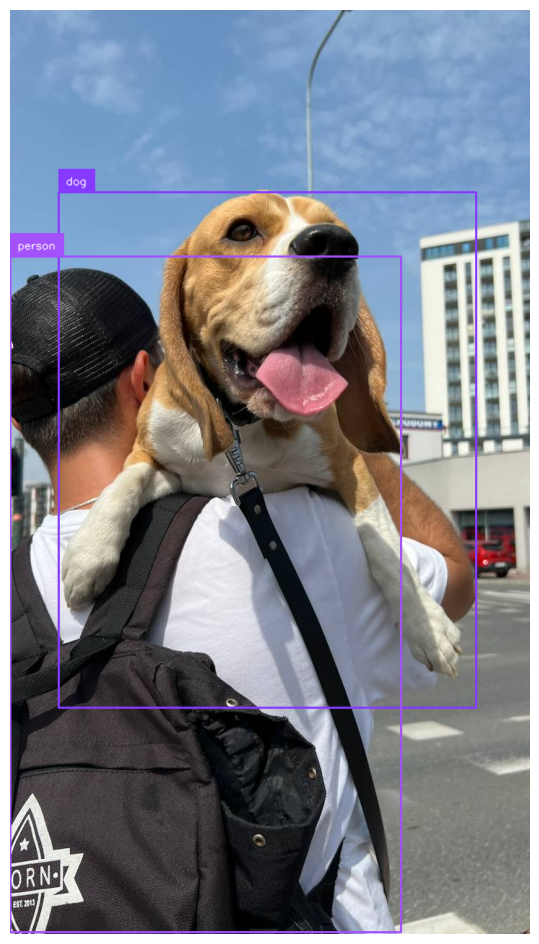

In [58]:
import cv2
import supervision as sv
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
image = cv2.imread(f'{HOME}/data/dog.jpeg')
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe
we have created a custom dataset for this. we have to download that from roboflow.

In [59]:
#!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="5SCBTm9KWPaqGZi9YyHs")
project = rf.workspace("main-jdzjs").project("bird-dataset-eoizo")
version = project.version(1)
dataset = version.download("yolov8")



/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`


**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow Universe, run the command below. 👇🏻

In [60]:
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !sed -i '$d' {dataset.location}/data.yaml
# !echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

## Custom Training

In [61]:
%cd {HOME}

!yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.48 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10n.pt, data=/content/datasets/Bird-dataset-1/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes

In [68]:
!ls {HOME}/runs/detect/train3/

args.yaml					     P_curve.png       train_batch2.jpg
confusion_matrix_normalized.png			     PR_curve.png      val_batch0_labels.jpg
confusion_matrix.png				     R_curve.png       val_batch0_pred.jpg
events.out.tfevents.1720090453.c7e17ee4a6f4.20239.0  results.csv       val_batch1_labels.jpg
F1_curve.png					     results.png       val_batch1_pred.jpg
labels_correlogram.jpg				     train_batch0.jpg  weights
labels.jpg					     train_batch1.jpg


/content


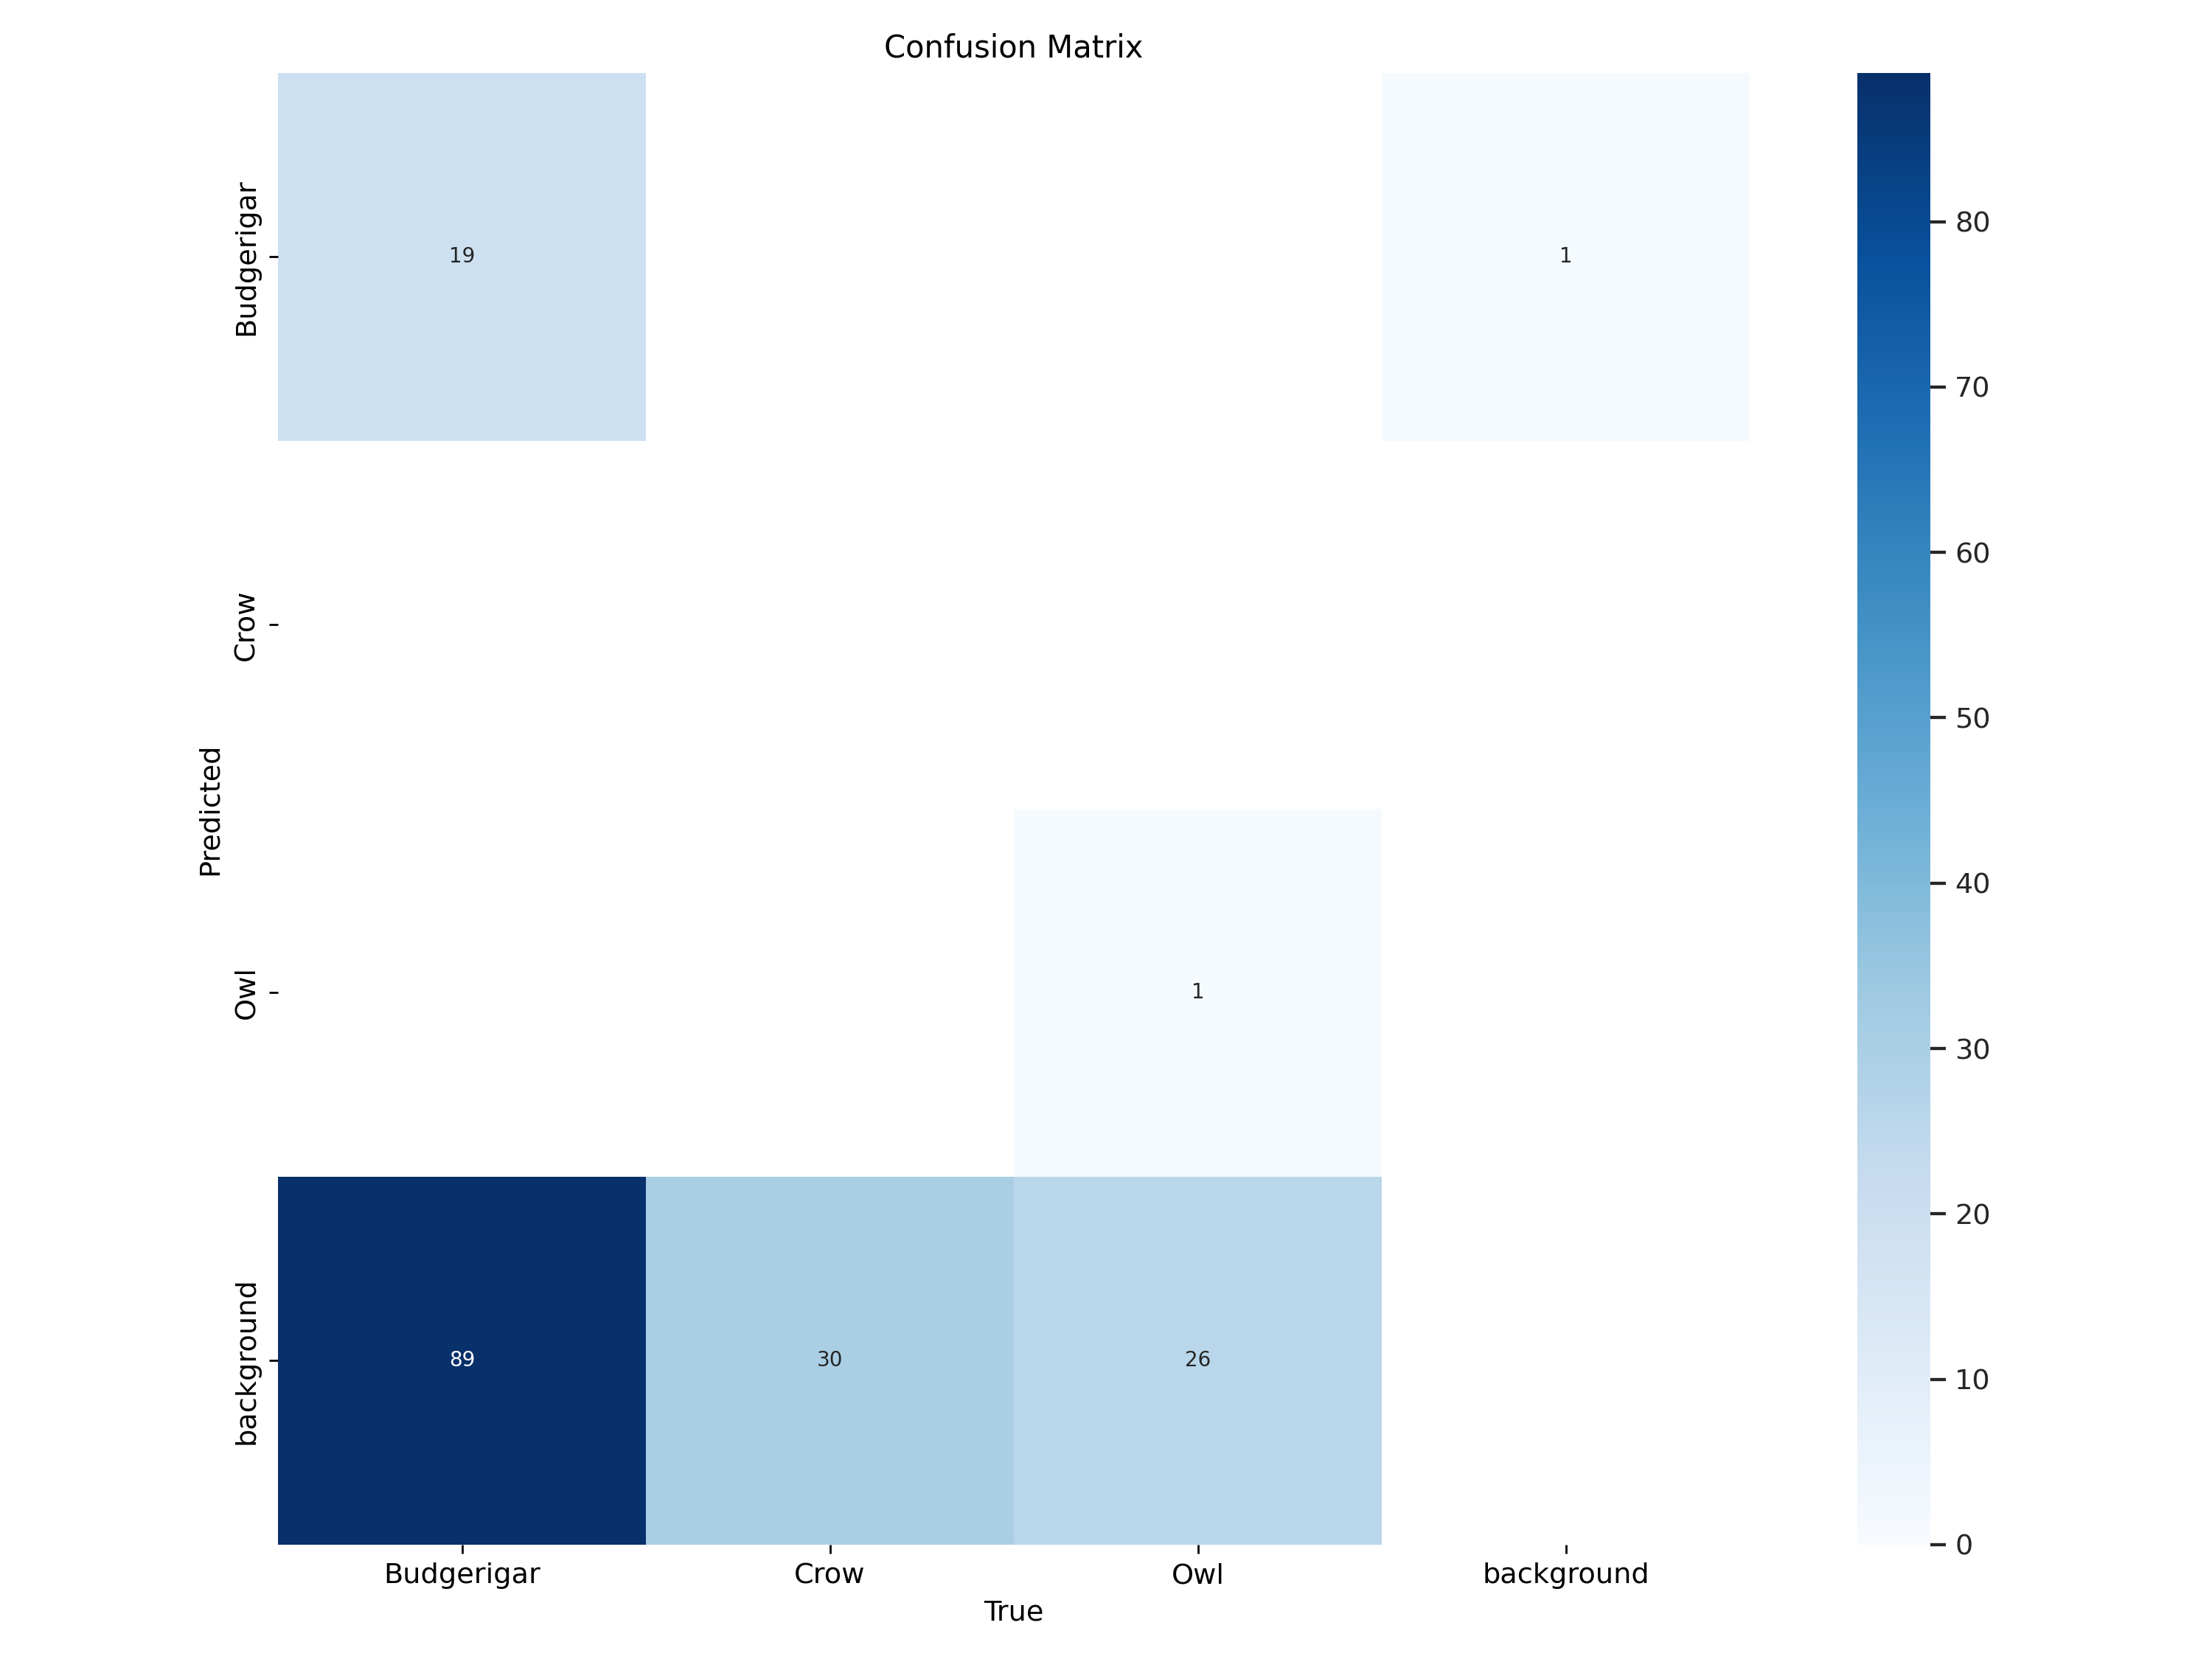

In [69]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix.png', width=600)

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content


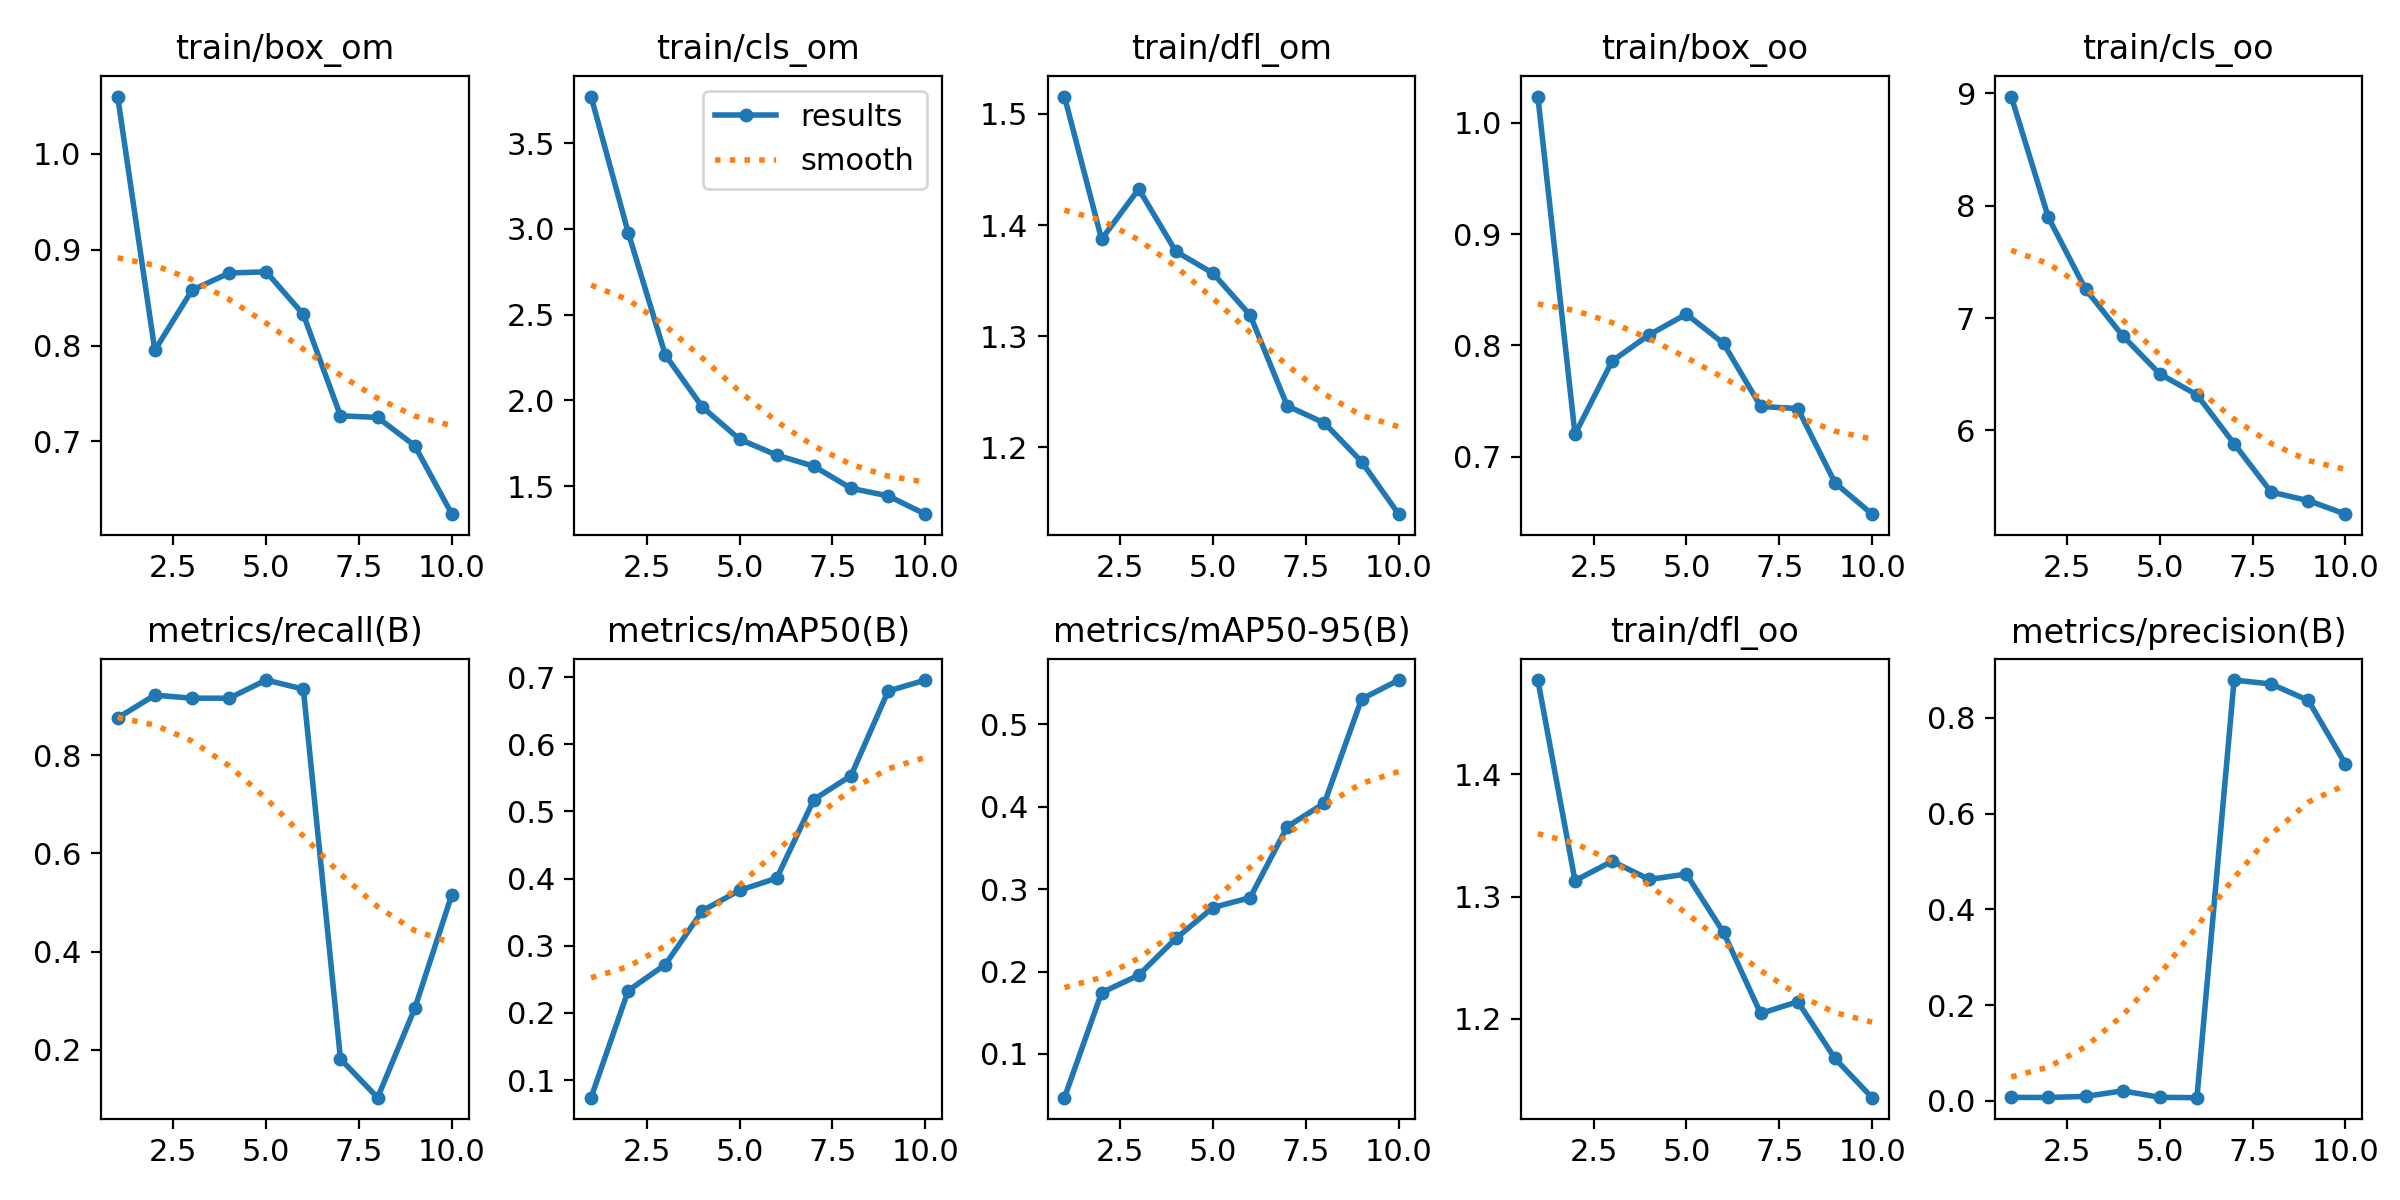

In [70]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/results.png', width=600)

## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [112]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train3/weights/best.pt')

dataset_location = "/content/datasets/Bird-dataset-1"
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/train/images",
    annotations_directory_path=f"{dataset_location}/train/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

**NOTE:** Let's randomly select an image from our validation set and visualize the results.


0: 640x640 (no detections), 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


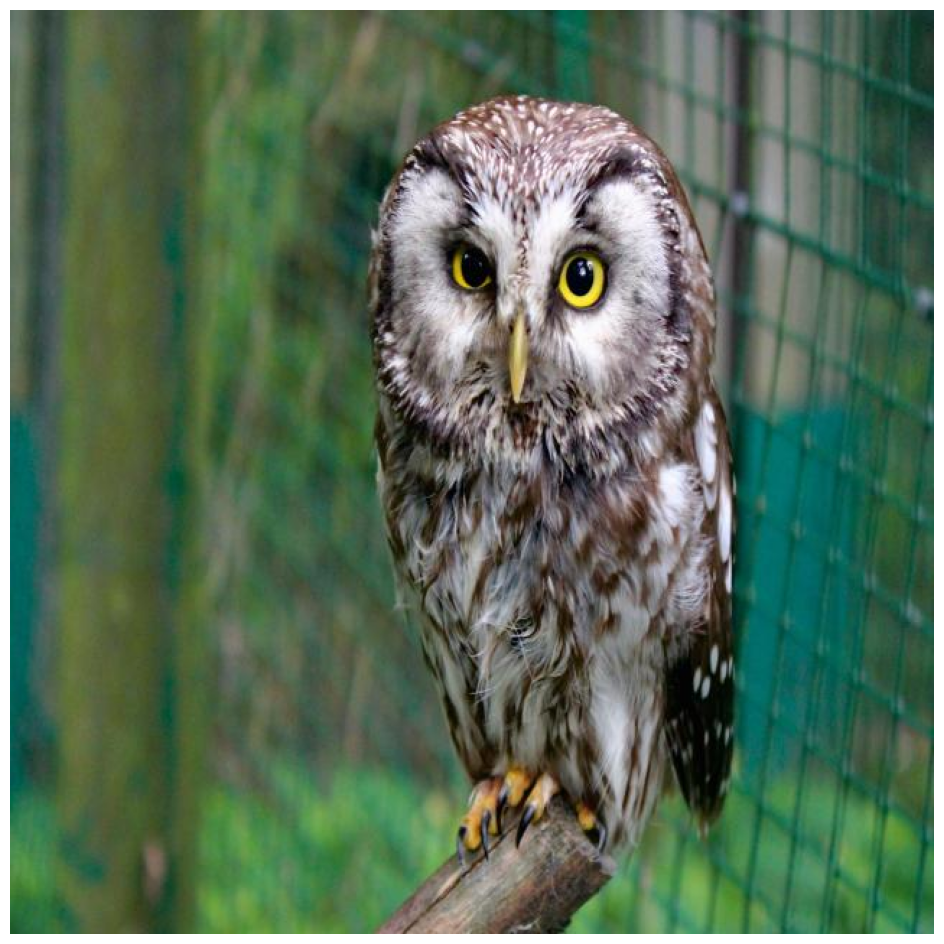

In [115]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)